# Retrieval System for Music Data

### Importing necessary libraries

In [1]:
#Importing necessary libraries
from ast import literal_eval
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
from IPython.display import display as ipy_display
from IPython.display import display, clear_output
from ipywidgets import Output
from ipywidgets import HBox

### Loading Datasets

In [2]:
# Load the datasets with the 'id' column as the index
tfidf_data = pd.read_csv('dataset/id_lyrics_tf-idf_mmsr.tsv', sep='\t', index_col='id')
bert_data = pd.read_csv('dataset/id_lyrics_bert_mmsr.tsv', sep='\t', index_col='id')
word2vec_data = pd.read_csv('dataset/id_lyrics_word2vec_mmsr.tsv', sep='\t', index_col='id')
info_data = pd.read_csv('dataset/id_information_mmsr.tsv', sep='\t')
info_data.head(3)

data_mfcc_bow = pd.read_csv('dataset/id_mfcc_bow_mmsr.tsv', sep='\t')
data_mfcc_bow = data_mfcc_bow.set_index('id')

# data_mfcc_bow.set_index(data_mfcc_bow.columns[0], inplace=True)


id_ivec256_mmsr = pd.read_csv('dataset/id_ivec256_mmsr.tsv', sep='\t')
id_ivec256_mmsr.set_index(id_ivec256_mmsr.columns[0], inplace=True)

id_ivec512_mmsr = pd.read_csv('dataset/id_ivec512_mmsr.tsv', sep='\t')


id_blf_correlation_mmsr = pd.read_csv('dataset/id_blf_correlation_mmsr.tsv', sep='\t')
id_blf_spectral_mmsr = pd.read_csv('dataset/id_blf_spectral_mmsr.tsv', sep='\t')

id_blf_spectral_mmsr.set_index(id_blf_spectral_mmsr.columns[0], inplace=True)

id_musicnn_mmsr = pd.read_csv('dataset/id_musicnn_mmsr.tsv', sep='\t')
id_musicnn_mmsr.set_index(id_musicnn_mmsr.columns[0], inplace=True)

id_incp_mmsr = pd.read_csv('dataset/id_incp_mmsr.tsv', sep='\t')
id_incp_mmsr = id_incp_mmsr.set_index('id')

id_resnet_mmsr = pd.read_csv('dataset/id_resnet_mmsr.tsv', sep='\t')
id_resnet_mmsr = id_resnet_mmsr.set_index('id')

id_url_mmsr = pd.read_csv('dataset/id_url_mmsr.tsv', sep='\t')

id_vgg19_mmsr = pd.read_csv('dataset/id_vgg19_mmsr.tsv', sep='\t')
id_vgg19_mmsr = id_vgg19_mmsr.set_index('id')

data_id_genres = pd.read_csv('dataset/id_genres_mmsr.tsv', sep='\t')

In [3]:
info_data.head(1)

,id,artist,song,album_name
0,01Yfj2T3YTwJ1Yfy,We As Human,Take The Bullets Away (feat. Lacey Sturm),We As Human


In [4]:
#id_url_mmsr.head()
#id_blf_spectral_mmsr.head()
#tfidf_data.head()
#data_mfcc_bow.head()
#data_mfcc_bow.index
#tfidf_data.index


### Defining the Four Test-Based Similarity Retrieval Systems

In [5]:
# Random Similarity
def random_song(song_id, other_song_id, data):
    return random.random()

# Jaccard Similarity
def jaccard_similarity(id1, id2, tfidf_data):
    vec1 = tfidf_data.loc[id1].astype(bool).values
    vec2 = tfidf_data.loc[id2].astype(bool).values
    intersection = np.sum(vec1 & vec2)
    union = np.sum(vec1 | vec2)
    return intersection / union if union != 0 else 0

# Cosine Similarity for Word2Vec and TF-IDF
def cosine_similarity_between_songs(id1, id2, embedding_data):
    vec1 = embedding_data.loc[id1].values.reshape(1, -1)
    vec2 = embedding_data.loc[id2].values.reshape(1, -1)
    return cosine_similarity(vec1, vec2)[0][0]


# Retrieval Function
def retrieve_similar_songs(song_id, embedding_data, similarity_function, info_data, top_n=10):
    similarities = {}
    for other_song_id in embedding_data.index:
        if other_song_id != song_id:
            # Use the provided similarity function
            similarity = similarity_function(song_id, other_song_id, embedding_data)
            similarities[other_song_id] = similarity
    sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:top_n]
    
    similar_songs_info = info_data[info_data['id'].isin([song_id for song_id, _ in sorted_similarities])]
    similar_songs_info = similar_songs_info.join(
        pd.DataFrame(sorted_similarities, columns=['id', 'similarity_score']).set_index('id'), 
        on='id'
    )
    
    return similar_songs_info

In [6]:
from sklearn.manifold import TSNE
def genre_hit_func(song_id_genres: list, other_song_genres: str):
    for genre in song_id_genres:
        if genre in other_song_genres:
            return 1
    else:
        return 0
    

def find_all_similar_songs(song_id, 
                           info_data, 
                           word2vec_data, 
                           tfidf_data, 
                           data_mfcc_bow,
                           id_ivec256_mmsr, 
                           id_blf_spectral_mmsr, 
                           id_musicnn_mmsr,
                           id_incp_mmsr,
                           id_resnet_mmsr,
                           id_vgg19_mmsr,
                           output_genre=False,
                           output_genre_hit=False,
                           data_id_genres=data_id_genres,
                           top_n=10):
    # Random method
    random_songs = info_data.sample(n=top_n).assign(method='random').assign(similarity_score=0.5)

    # Jaccard similarity
    jaccard_songs = retrieve_similar_songs(song_id, tfidf_data, jaccard_similarity, info_data, top_n).assign(method='jaccard')

    # Cosine similarity with TF-IDF
    tfidf_songs = retrieve_similar_songs(song_id, tfidf_data, cosine_similarity_between_songs, info_data, top_n).assign(method='tfidf')

    # Cosine similarity with Word2Vec embeddings
    word2vec_songs = retrieve_similar_songs(song_id, word2vec_data, cosine_similarity_between_songs, info_data, top_n).assign(method='word2vec')
    
    #Cosine similarity with MFCC Bow 
    mfcc_bow_songs = retrieve_similar_songs(song_id, data_mfcc_bow, cosine_similarity_between_songs, info_data, top_n).assign(method='mfcc_bow')
    
    #Cosine similarity with id_ivec256_mmsr  
    id_ivec256_mmsr_songs = retrieve_similar_songs(song_id, id_ivec256_mmsr, cosine_similarity_between_songs, info_data, top_n).assign(method='id_ivec256_mmsr')

    #Cosine similarity with id_blf_spectral_mmsr
    id_blf_spectral_mmsr_songs = retrieve_similar_songs(song_id, id_blf_spectral_mmsr, cosine_similarity_between_songs, info_data, top_n).assign(method='id_blf_spectral_mmsr')
    
    #Cosine similarity with id_musicnn_mmsr
    id_musicnn_mmsr_songs = retrieve_similar_songs(song_id, id_musicnn_mmsr, cosine_similarity_between_songs, info_data, top_n).assign(method='id_musicnn_mmsr')

    ### Video based
    #Cosine similarity with id_incp_mmsr
    id_incp_mmsr_songs = retrieve_similar_songs(song_id, id_incp_mmsr, cosine_similarity_between_songs, info_data, top_n).assign(method='id_incp_mmsr')

    #Cosine similarity with id_resnet_mmsr
    id_resnet_mmsr_songs = retrieve_similar_songs(song_id, id_resnet_mmsr, cosine_similarity_between_songs, info_data, top_n).assign(method='id_resnet_mmsr')

    # #Cosine similarity with id_url_mmsr
    # id_url_mmsr

    #Cosine similarity with id_vgg19_mmsr
    id_vgg19_mmsr_songs = retrieve_similar_songs(song_id, id_vgg19_mmsr, cosine_similarity_between_songs, info_data, top_n).assign(method='id_vgg19_mmsr')

    ### Early fusion:
    #early_fusion_data = pd.concat([data_mfcc_bow,id_vgg19_mmsr], axis=1)
    #early_fusion_index = early_fusion_data.index
    #early_fusion_pca = PCA(n_components=300)
    #early_fusion_data = early_fusion_pca.fit_transform(early_fusion_data)
    #early_fusion_data = pd.DataFrame(early_fusion_data, index=early_fusion_index)

    #early_fusion_mmsr_songs = retrieve_similar_songs(song_id, early_fusion_data, cosine_similarity_between_songs, info_data, top_n).assign(method='early_fusion')
    
    #Early fusion with t-SNE
    #if method == 'early_fusion':
    early_fusion_data = pd.concat([data_mfcc_bow, id_vgg19_mmsr], axis=1)
    early_fusion_index = early_fusion_data.index
    early_fusion_tsne = TSNE(n_components=2)
    early_fusion_data = early_fusion_tsne.fit_transform(early_fusion_data)
    early_fusion_data = pd.DataFrame(early_fusion_data, index=early_fusion_index)

    early_fusion_mmsr_songs = retrieve_similar_songs(song_id, early_fusion_data, cosine_similarity_between_songs, info_data, top_n).assign(method='early_fusion_tsne')

    ### Late fusion:
    late_fusion_scores = (mfcc_bow_songs['similarity_score'] + id_vgg19_mmsr_songs['similarity_score']) / 2
    late_fusion_data = mfcc_bow_songs.drop(columns=['similarity_score'])
    late_fusion_mmsr_songs = pd.merge(late_fusion_data, late_fusion_scores, left_index=True, right_index=True)
    late_fusion_mmsr_songs['method'] = 'late_fusion'
    

    ### Concatenate all results
    all_results_df = pd.concat([random_songs, 
                                jaccard_songs, 
                                tfidf_songs, 
                                word2vec_songs,
                                mfcc_bow_songs,
                                id_ivec256_mmsr_songs,
                                id_blf_spectral_mmsr_songs,
                                id_musicnn_mmsr_songs,
                                id_incp_mmsr_songs,
                                id_resnet_mmsr_songs,
                                id_vgg19_mmsr_songs,
                                early_fusion_mmsr_songs,
                                late_fusion_mmsr_songs])
    
    if output_genre:
        all_results_df = pd.merge(all_results_df,
                                data_id_genres,
                                on='id')
        # Value to use for evaluation later on
        if output_genre_hit:
            song_id_genres = literal_eval(data_id_genres[data_id_genres['id'] == id]['genre'].values[0])
            
            all_results_df['genre_hit'] = all_results_df['genre'].apply(lambda g: genre_hit_func(song_id_genres, g))
    
    return all_results_df

### Evaluation (@10)

In [7]:
select_ids = info_data['id'].sample(n=200)
#select_ids = info_data['id'] # To use all the ids
n_ids = len(select_ids)
k = 10

results_10 = dict()

for id in tqdm(select_ids, desc=f'Evaluating ids...'):

    similar_songs = find_all_similar_songs(song_id=id, 
                                            info_data=info_data, 
                                            word2vec_data=word2vec_data,
                                            tfidf_data=tfidf_data,
                                            data_mfcc_bow=data_mfcc_bow,
                                            id_ivec256_mmsr=id_ivec256_mmsr,
                                            id_blf_spectral_mmsr=id_blf_spectral_mmsr,
                                            id_musicnn_mmsr=id_musicnn_mmsr,
                                            id_incp_mmsr=id_incp_mmsr,
                                            id_resnet_mmsr=id_resnet_mmsr,
                                            id_vgg19_mmsr=id_vgg19_mmsr,
                                            output_genre=True,
                                            output_genre_hit=True,
                                            data_id_genres=data_id_genres,  # Add data_id_genres as an argument
                                            top_n=len(info_data))

    for method in similar_songs['method'].unique():

        if method not in results_10:
            results_10[method] = {'precision': 0,
                                    'recall': 0,
                                    'ndcg': 0,
                                  'genre_coverage': 0,
                                 'genre_diversity': 0}

        method_data = similar_songs[similar_songs['method'] == method]
        method_data = method_data.sort_values('similarity_score', ascending=False)

        genre_hit = method_data['genre_hit']
        similarity_score = method_data['similarity_score']

        # Precision@k
        tp = sum(genre_hit[:k])
        fp = k - tp
        results_10[method]['precision'] += (tp / k) / n_ids # Average

        # Recall@k
        #results_10[method]['recall'] += (tp / sum(genre_hit)) / n_ids # Average
        # Recall@k
        relevant_items = sum(genre_hit)
        retrieved_items = sum(genre_hit[:k])
        results_10[method]['recall'] += ((retrieved_items / relevant_items) / n_ids)*100  # Average

        
        
        # nDCG@k
        results_10[method]['ndcg'] += (ndcg_score(genre_hit[:k].values.reshape(1, -1), 
                                                similarity_score[:k].values.reshape(1, -1))) / n_ids # Average

        # Genre coverage
        genre_coverage = sum(genre_hit) / len(genre_hit)
        results_10[method]['genre_coverage'] += genre_coverage / n_ids  # Average
        
        # Genre diversity
        genre_diversity = len(genre_hit.unique())
        results_10[method]['genre_diversity'] += genre_diversity / n_ids  # Average

        

Evaluating ids...: 100%|██████████| 200/200 [3:48:27<00:00, 68.54s/it]   


In [8]:
results_10_df = pd.DataFrame(results_10).T
results_10_df

,precision,recall,ndcg,genre_coverage,genre_diversity
random,0.5495,0.101199,0.727300,0.540500,2.0
jaccard,0.6230,0.143258,0.773945,0.540454,2.0
tfidf,0.5840,0.116255,0.749868,0.540454,2.0
word2vec,0.5945,0.136840,0.763954,0.540454,2.0
mfcc_bow,0.6525,0.133549,0.794523,0.540454,2.0
id_ivec256_mmsr,0.6325,0.139766,0.792384,0.540454,2.0
id_blf_spectral_mmsr,0.6685,0.139118,0.796412,0.540454,2.0
id_musicnn_mmsr,0.6935,0.168015,0.823043,0.540454,2.0
id_incp_mmsr,0.6310,0.140472,0.805138,0.540454,2.0
id_resnet_mmsr,0.6335,0.146213,0.813807,0.540454,2.0


### Evaluation @ 1 - 100

In [9]:
select_ids = info_data['id'].sample(n=50)
#select_ids = info_data['id'] # To use all the ids
n_ids = len(select_ids)

results = dict()

for id in tqdm(select_ids, desc=f'Evaluating ids...'):

    for k in range(1, 101, 10):
    # for k in range(2, 101): # To use all the ks from 2 to 100

        if k not in results:
            results[k] = dict()

        similar_songs = find_all_similar_songs(song_id=id, 
                                                info_data=info_data, 
                                                word2vec_data=word2vec_data,
                                                tfidf_data=tfidf_data,
                                                data_mfcc_bow=data_mfcc_bow,
                                                id_ivec256_mmsr=id_ivec256_mmsr,
                                                id_blf_spectral_mmsr=id_blf_spectral_mmsr,
                                                id_musicnn_mmsr=id_musicnn_mmsr,
                                                id_incp_mmsr=id_incp_mmsr,
                                                id_resnet_mmsr=id_resnet_mmsr,
                                                id_vgg19_mmsr=id_vgg19_mmsr,
                                                output_genre=True,
                                                output_genre_hit=True,
                                                top_n=len(info_data))

        for method in similar_songs['method'].unique():

            if method not in results[k]:
                results[k][method] = {'precision': 0,
                                      'recall': 0}

            method_data = similar_songs[similar_songs['method'] == method]
            method_data = method_data.sort_values('similarity_score', ascending=False)

            genre_hit = method_data['genre_hit']
            similarity_score = method_data['similarity_score']

            # Precision@k
            tp = sum(genre_hit[:k])
            fp = k - tp
            results[k][method]['precision'] += (tp / k) / n_ids # Average

            # Recall@k
            results[k][method]['recall'] += (tp / sum(genre_hit)) / n_ids # Average

Evaluating ids...: 100%|██████████| 50/50 [13:58:59<00:00, 1006.78s/it]   


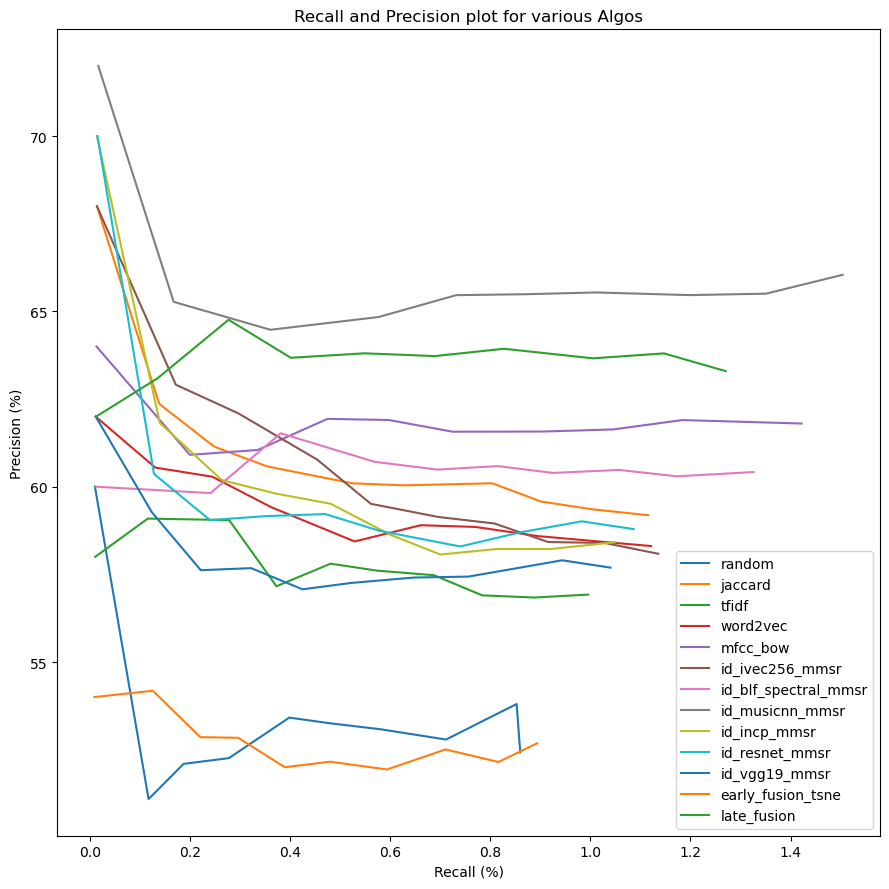

In [15]:
all_methods = similar_songs['method'].unique()
ks = range(1, 101, 10)

plt.figure(figsize=(9, 9))

for i, method in enumerate(all_methods):
    method_prec = [results[k][method]['precision']*100 for k in ks]
    method_rec = [results[k][method]['recall']*100 for k in ks]

    plt.plot(method_rec, method_prec)

plt.xlabel('Recall (%)')
plt.ylabel('Precision (%)')
plt.title('Recall and Precision plot for various Algos')
plt.legend(all_methods)

plt.tight_layout()
plt.show()

In [16]:
# def find_all_similar_songs1(song_id, info_data, word2vec_data, tfidf_data, top_n=10):
#     #Cosine similarity with MFCC Bow 
#     mfcc_bow_songs = retrieve_similar_songs(song_id, data_mfcc_bow, cosine_similarity_between_songs, info_data, top_n).assign(method='mfcc_bow')
    
#     return mfcc_bow_songs

In [17]:
# find_all_similar_songs1('01Yfj2T3YTwJ1Yfy', info=info_data, data_mfcc_bow)

In [18]:
# retrieve_similar_songs('GDGURAgKxNPEuXzM', data_mfcc_bow, cosine_similarity_between_songs, info_data, top_n=5 )

In [19]:
# print(data_mfcc_bow.'01Yfj2T3YTwJ1Yfy')

### Defining the display and interactive functions 

In [20]:
def display_similar_songs(all_similar_songs_df, song_name, artist_name):
    for method, group_df in all_similar_songs_df.groupby('method'):
        print(f"\nSongs similar to '{song_name}' by '{artist_name}' using {method.upper()} method are:")
        ipy_display(group_df.drop(columns=['method', 'similarity_score'], errors='ignore'))

        
def get_song_id_by_name_artist(song_name, artist_name, info_data):
    matched_songs = info_data[
        (info_data['song'].str.lower().str.strip() == song_name.lower().strip()) &
        (info_data['artist'].str.lower().str.strip() == artist_name.lower().strip())
    ]
    if not matched_songs.empty:
        return matched_songs.iloc[0]['id']
    else:
        return None
        
        
def interactive_song_retrieval(song_name, artist_name, method, top_n):
    song_id = get_song_id_by_name_artist(song_name, artist_name, info_data)
    if song_id is not None:
        if method == 'All':
            all_similar_songs_df = find_all_similar_songs(song_id, 
                                                          info_data, 
                                                          word2vec_data, 
                                                          tfidf_data, 
                                                          data_mfcc_bow,  
                                                          id_ivec256_mmsr, 
                                                          id_blf_spectral_mmsr, 
                                                          id_musicnn_mmsr,
                                                          id_incp_mmsr,
                                                          id_resnet_mmsr,
                                                          id_vgg19_mmsr,
                                                          top_n)
            display_similar_songs(all_similar_songs_df, song_name, artist_name)
        else:
            # Call the individual method directly
            if method == 'Random':
                display_songs = info_data.sample(top_n)
            elif method == 'Jaccard':
                display_songs = retrieve_similar_songs(song_id, tfidf_data, jaccard_similarity, info_data, top_n)
            elif method == 'TF-IDF':
                display_songs = retrieve_similar_songs(song_id, tfidf_data, cosine_similarity_between_songs, info_data, top_n)
            elif method == 'Word2Vec':
                display_songs = retrieve_similar_songs(song_id, word2vec_data, cosine_similarity_between_songs, info_data, top_n)
            elif method == 'data_mfcc_bow':
                display_songs = retrieve_similar_songs(song_id, data_mfcc_bow, cosine_similarity_between_songs, info_data, top_n)
            elif method == 'id_ivec256_mmsr':
                display_songs = retrieve_similar_songs(song_id, id_ivec256_mmsr, cosine_similarity_between_songs, info_data, top_n)
            elif method == 'id_blf_spectral_mmsr':
                display_songs = retrieve_similar_songs(song_id, id_blf_spectral_mmsr, cosine_similarity_between_songs, info_data, top_n)
            elif method == 'id_musicnn_mmsr':
                display_songs = retrieve_similar_songs(song_id, id_musicnn_mmsr, cosine_similarity_between_songs, info_data, top_n)
            ### Video based
            elif method == 'id_incp_mmsr':
                display_songs = retrieve_similar_songs(song_id, id_incp_mmsr, cosine_similarity_between_songs, info_data, top_n).assign(method='id_incp_mmsr')
            elif method == 'id_resnet_mmsr':
                display_songs = retrieve_similar_songs(song_id, id_resnet_mmsr, cosine_similarity_between_songs, info_data, top_n).assign(method='id_resnet_mmsr')
            elif method == 'id_vgg19_mmsr':
                display_songs = retrieve_similar_songs(song_id, id_vgg19_mmsr, cosine_similarity_between_songs, info_data, top_n).assign(method='id_vgg19_mmsr')
                
                
        
            # Display the DataFrame without the similarity score and method columns
            display_songs = display_songs.drop(columns=['similarity_score'], errors='ignore')
            print(f"\nSongs similar to '{song_name}' by {artist_name} using {method.upper()} method are:")
            ipy_display(display_songs)
    else:
        print("Song not found. Please check the song name and artist.")

# Assuming the interactive widget has been set up as previously described
# Create widgets
song_name_widget = widgets.Text(
    value='',  # No default value
    placeholder='Enter song title',  # Placeholder text
    description='Song:',  # Label for the input box
    disabled=False
)

artist_name_widget = widgets.Text(
    value='',  # No default value
    placeholder='Enter artist name',  # Placeholder text
    description='Artist:',  # Label for the input box
    disabled=False
)

method_widget = widgets.Dropdown(options=['All', 
                                          'Random', 
                                          'Jaccard', 
                                          'TF-IDF', 
                                          'Word2Vec',
                                          'data_mfcc_bow',
                                          'id_ivec256_mmsr', 
                                          'id_blf_spectral_mmsr', 
                                          'id_musicnn_mmsr',
                                          'id_incp_mmsr',
                                          'id_resnet_mmsr',
                                          'id_vgg19_mmsr'], 
                                value='All', 
                                description='Method:', 
                                disabled=False)

# Slider for number of tracks
n_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description='N-Tracks:', continuous_update=False)

# Widget to trigger the interactive retrieval
interactive_widget = widgets.interactive(
    interactive_song_retrieval,
    song_name=song_name_widget,
    artist_name=artist_name_widget,
    method=method_widget,
    top_n=n_slider  # Check this linkage
)


# Display the widget
ipy_display(interactive_widget)

interactive(children=(Text(value='', description='Song:', placeholder='Enter song title'), Text(value='', desc…

In [21]:
info_data

,id,artist,song,album_name
0,01Yfj2T3YTwJ1Yfy,We As Human,Take The Bullets Away (feat. Lacey Sturm),We As Human
1,01gyRHLquwXDlhkO,The Notorious B.I.G.,Somebody's Gotta Die,Life After Death (Remastered Edition)
2,01rMxQv6vhyE1oQX,Against the Current,Chasing Ghosts,In Our Bones
3,02RGE9FNH65RtMS7,Barthezz,Infected,Trance - The Early Years (1997-2002)
4,02ZnlCGZEbkfCDxo,Laura Pausini,Tra Te E Il Mare,The Best of Laura Pausini - E Ritorno Da Te
...,...,...,...,...
10090,zyzILCQvVeUFIINi,Crowded House,When You Come,Temple Of Low Men
10091,zzgS4ZqyswamEWNj,Britney Spears,My Only Wish (This Year),Platinum Christmas
10092,zzoFYDMlqU1X2zz1,Thundercat,DUI,Drunk
10093,zzpkRCGA5ud8q4mv,Otis Redding,Rock Me Baby,Otis Blue


### Query and Retrieval Systems

In [22]:
# Initialize widgets for song and artist input
song_artist_widgets = []
for i in range(1, 4):  # Assuming 3 songs for analysis
    song_widget = widgets.Text(placeholder='Enter song title', description=f'Song {i}:')
    artist_widget = widgets.Text(placeholder='Enter artist name', description=f'Artist {i}:')
    song_artist_widgets.append((song_widget, artist_widget))

# Initialize other widgets
method_widget = widgets.Dropdown(options=['All', 'Random', 'Jaccard', 'TF-IDF', 'Word2Vec'], value='All', description='Method:')
n_slider = widgets.IntSlider(value=10, min=1, max=20, step=1, description='N-Tracks:', continuous_update=False)
retrieve_button = widgets.Button(description='Get the damn Song', tooltip='Click to retrieve similar songs')
output_area = widgets.Output()

# Function to handle the retrieval
def on_retrieve_button_clicked(b):
    with output_area:
        clear_output()
        for song_widget, artist_widget in song_artist_widgets:
            song_name, artist_name = song_widget.value.strip(), artist_widget.value.strip()
            method, top_n = method_widget.value, n_slider.value
            if song_name and artist_name:
                if method == 'All':
                    methods = ['Random', 'Jaccard', 'TF-IDF', 'Word2Vec']
                    for m in methods:
                        interactive_song_retrieval(song_name, artist_name, m, top_n)
                else:
                    interactive_song_retrieval(song_name, artist_name, method, top_n)
            else:
                print(f"Enter both song title and artist name for {song_widget.description} and {artist_widget.description}")

# Link button click to handler
retrieve_button.on_click(on_retrieve_button_clicked)

# Display all widgets
display_layout = widgets.VBox([
    widgets.HBox([song_widget, artist_widget]) for song_widget, artist_widget in song_artist_widgets
] + [method_widget, n_slider, retrieve_button, output_area])

ipy_display(display_layout)